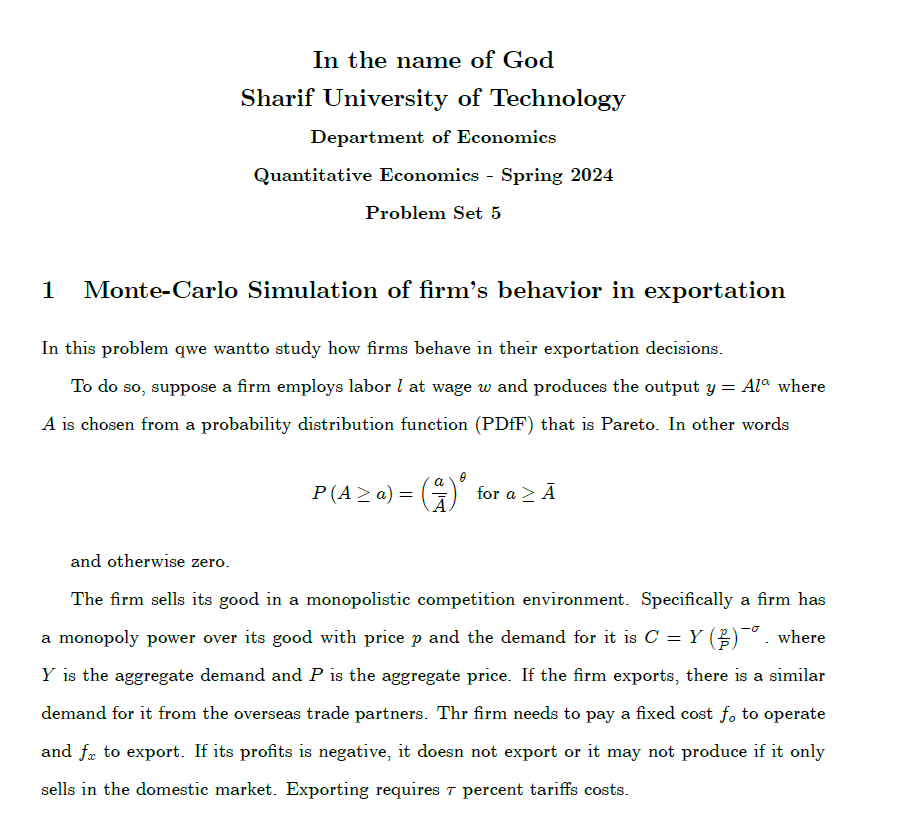

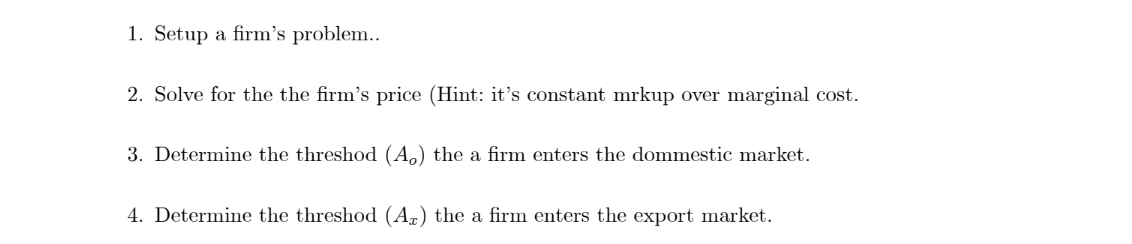

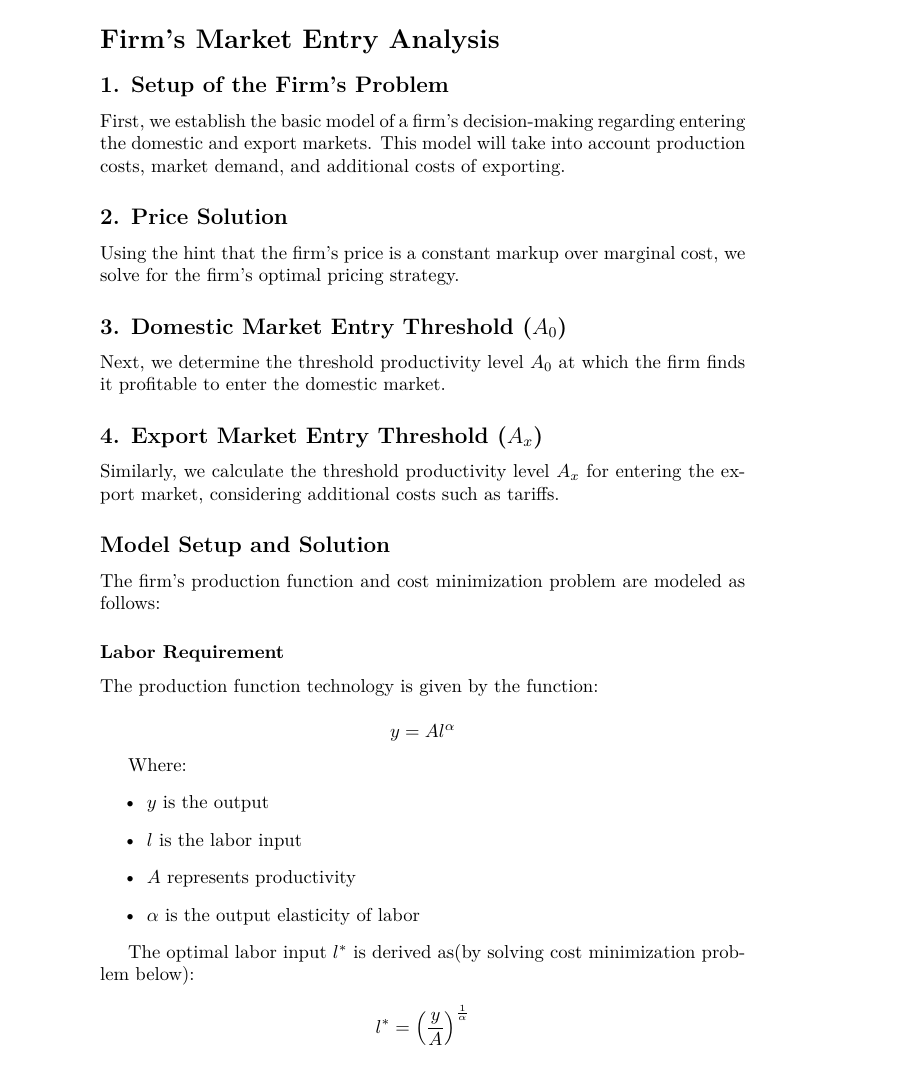

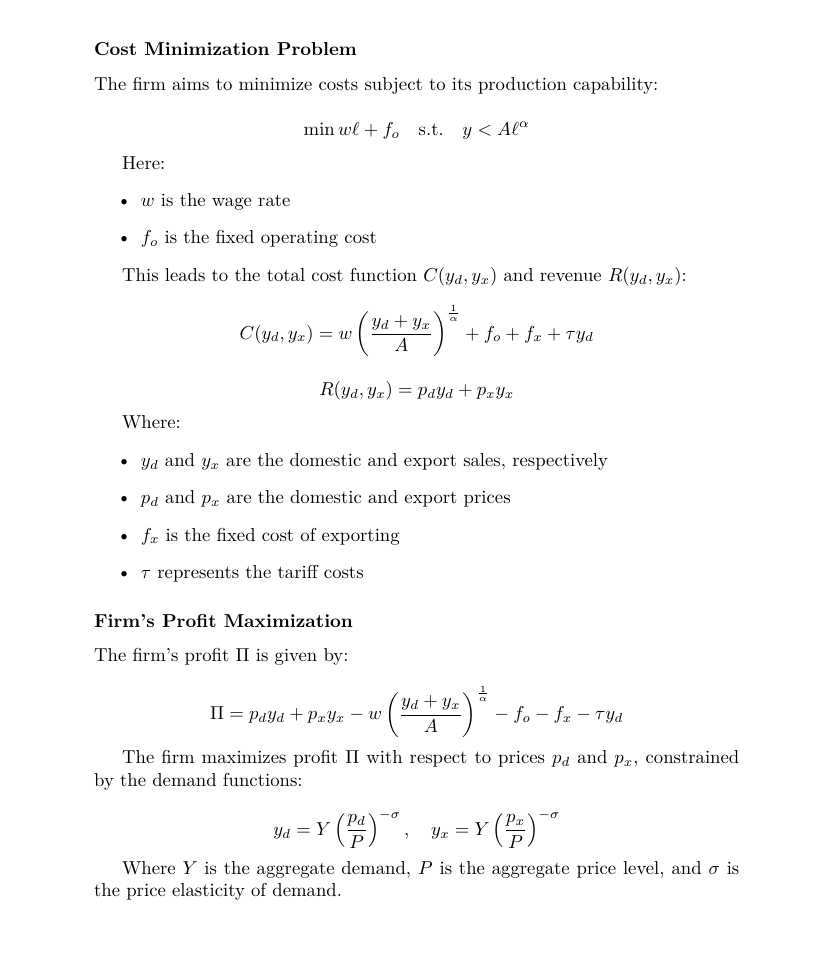

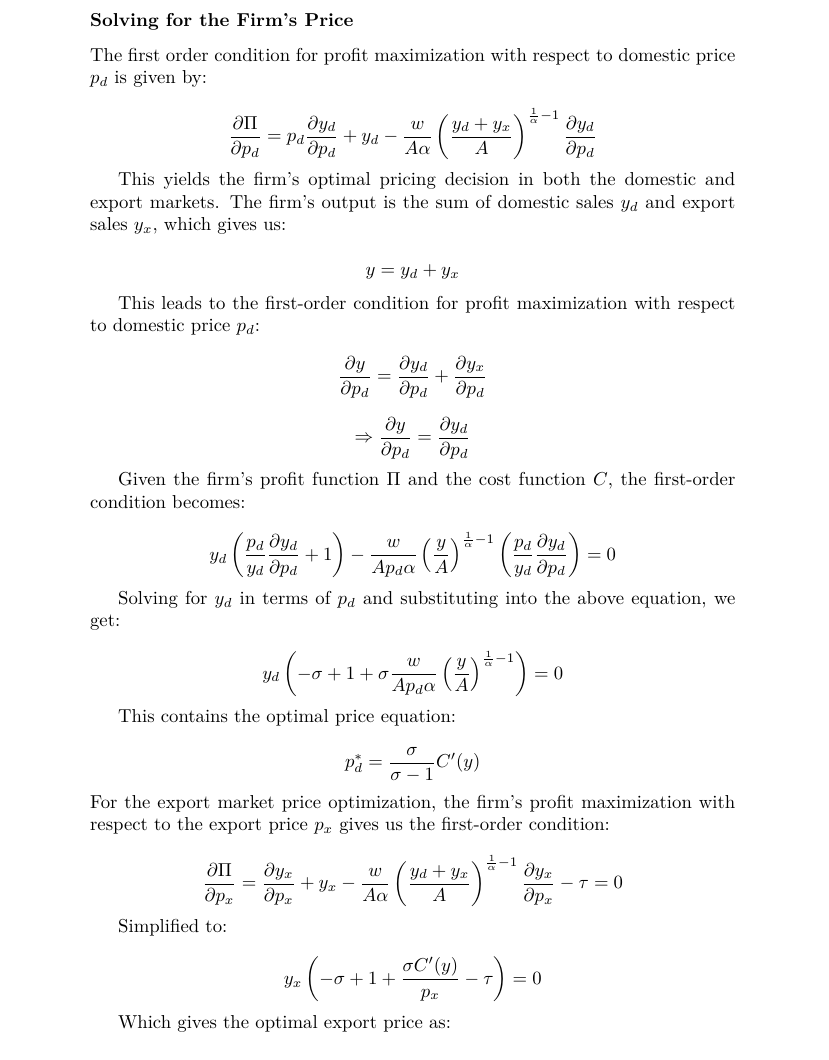

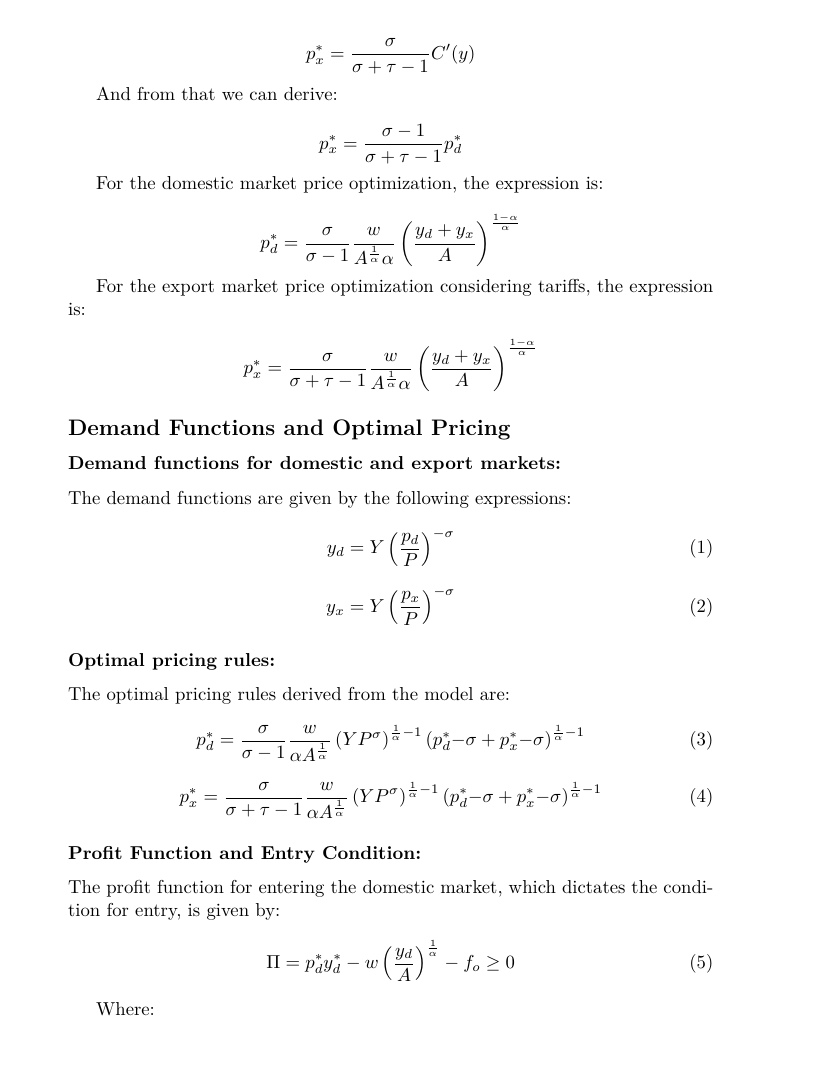

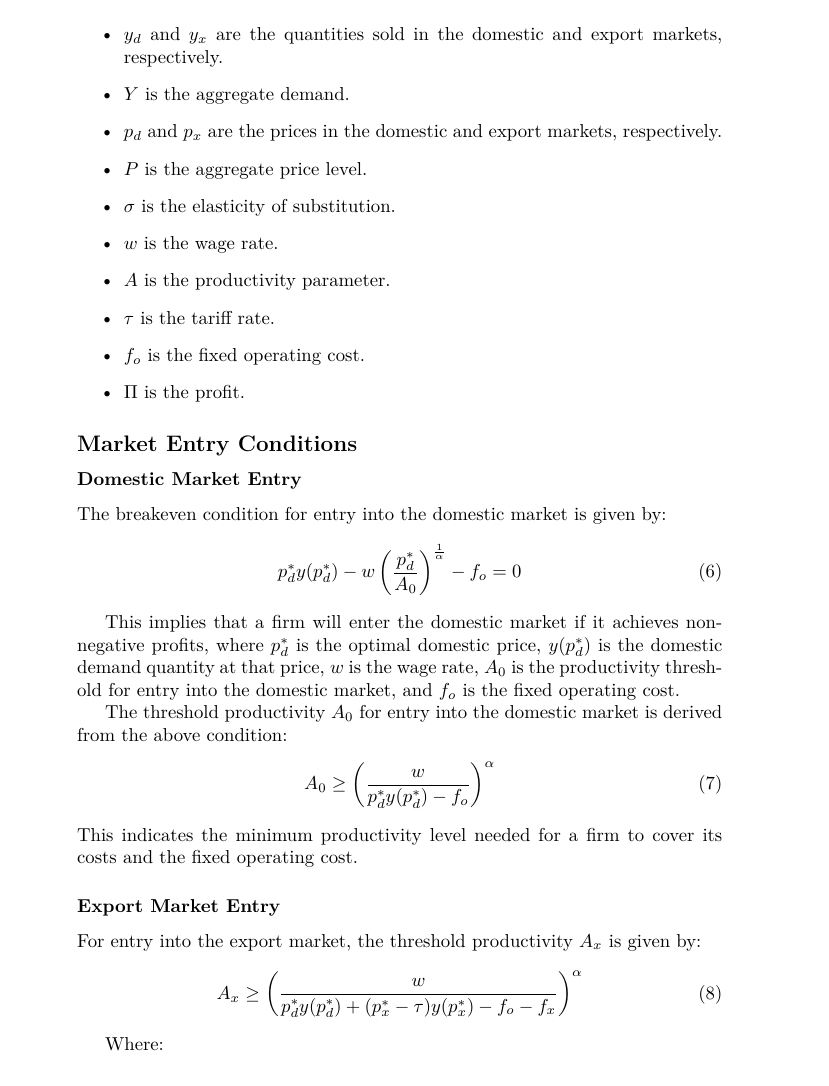

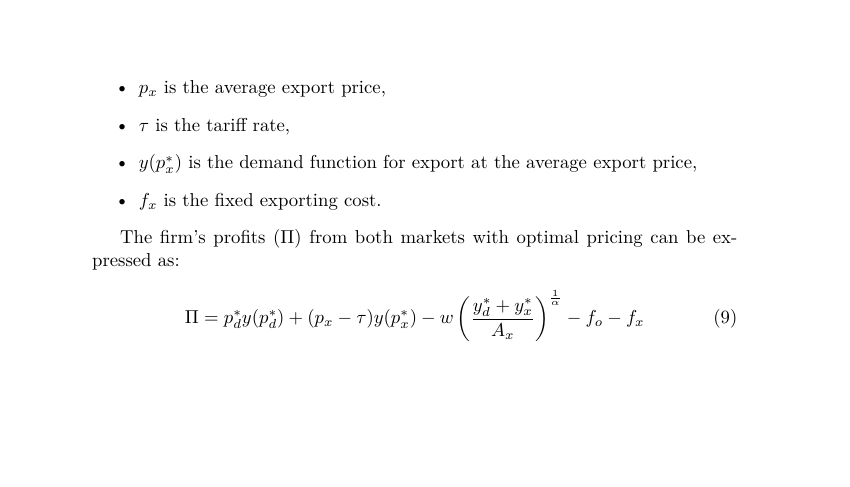

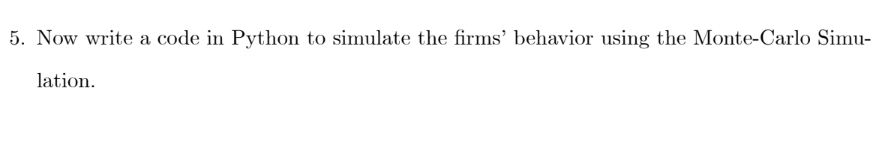

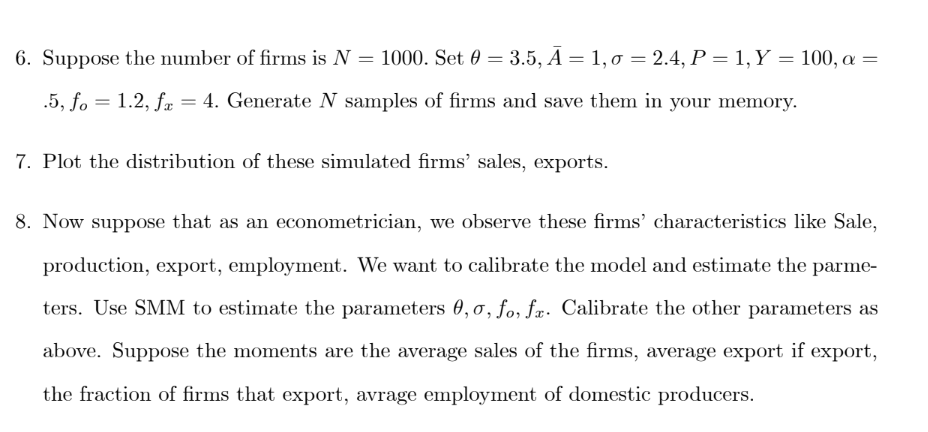

In [1]:
import numpy as np
from scipy.optimize import fsolve

# Set up model parameters
N = 1000  # Number of firms
theta = 3.5  # Shape parameter of the Pareto distribution for A
A_bar = 1  # Minimum productivity level
sigma = 2.4  # Elasticity of substitution
P = 1  # Aggregate price level
Y = 100  # Aggregate demand
alpha = 0.5  # Output elasticity with respect to labor
f_o = 1.2  # Fixed operational cost
f_x = 4  # Fixed export cost
w = 2  # Wage rate
tau = 0.1  # Tariff rate as a percentage

# Define a function to calculate the optimal domestic price before firm joins exporters
def find_optimal_price_domestic(A):
    # Equation to find the optimal domestic price when the firm is not exporting (p_x = 0)
    def equation(p_d):
        return p_d - (sigma / (sigma - 1)) * (w / alpha) * A**(-alpha) * Y**(1/alpha - 1) * P**(sigma*(1/alpha - 1)) * p_d**(-sigma * (1/alpha - 1))
    # Initial guess for the domestic price
    initial_guess = [w]
    # Solve the equation to find the optimal domestic price
    p_d_optimal = fsolve(equation, initial_guess)[0]
    return p_d_optimal

# Define a function to calculate the optimal prices after firm joins exporters
def find_optimal_prices_exporters(A):
    # Define equations to find optimal prices when the firm is exporting
    def equations(p):
        p_d, p_x = p
        return (
            p_d - (sigma / (sigma - 1)) * (w / alpha) * A**(-alpha) * Y**(1/alpha - 1) * P**(sigma*(1/alpha - 1)) * (p_d**(-sigma) + p_x**(-sigma))**(1/alpha - 1),
            p_x - (sigma / (sigma + tau - 1)) * p_d
        )
    # Initial guess for the prices
    initial_guess = [w, w]
    # Solve the equations
    p_d, p_x = fsolve(equations, initial_guess)
    return p_d, p_x

# Simulate firms' behavior
profits_list = []
y_d_list = []
y_x_list = []
output_list = []
labor_list = []
domestic_prices_list = []
export_prices_list = []
sales_list = []
prod_list = []
for _ in range(N):
    # Draw a productivity level from Pareto distribution
    A = (np.random.pareto(theta) + 1) * A_bar
    p_d_domestic = find_optimal_price_domestic(A)
    p_d_exporter, p_x_exporter = find_optimal_prices_exporters(A)

    # Calculate profits and quantities for domestic only scenario
    y_d_domestic = Y * (p_d_domestic / P)**(-sigma)
    costs_domestic = w * (y_d_domestic / A)**(1/alpha) + f_o
    profits_domestic = p_d_domestic * y_d_domestic - costs_domestic

    # Calculate profits and quantities for export scenario
    y_d_exporter = Y * (p_d_exporter / P)**(-sigma)
    y_x_exporter = Y * (p_x_exporter / P)**(-sigma)
    costs_exporter = w * ((y_d_exporter + y_x_exporter) / A)**(1/alpha) + f_o + f_x + tau * y_x_exporter
    profits_exporter = p_d_exporter * y_d_exporter + p_x_exporter * y_x_exporter - costs_exporter

    # Determine the firm's behavior based on profits
    if profits_domestic > 0 and profits_exporter > 0:
        # The firm will export
        profits = profits_exporter
        y_d = y_d_exporter
        y_x = y_x_exporter
        p_d = p_d_exporter
        p_x = p_x_exporter
    elif profits_domestic > 0 and profits_exporter <= 0:
        # The firm will only sell domestically
        profits = profits_domestic
        y_d = y_d_domestic
        y_x = 0
        p_d = p_d_domestic
        p_x = 0
        
    else:
        # The firm will not sell at all
        profits = 0
        y_d = 0
        y_x = 0
        p_d = 0
        p_x = 0
    output = y_d + y_x
    labor = (output / A)**(1 / alpha)
    productivity = output / labor

    profits_list.append(profits)
    y_d_list.append(y_d)
    y_x_list.append(y_x)
    output_list.append(output)
    labor_list.append(labor)
    domestic_prices_list.append(p_d)
    export_prices_list.append(p_x)
    sales_list.append(p_x * y_x + p_d * y_d)
    prod_list.append(productivity)
    


In [3]:
 
y_d_array = np.array(y_d_list)
y_x_array = np.array(y_x_list)
sales_array = np.array(sales_list)
labor_array = np.array(labor_list)
prod_array = np.array(prod_list)

# Average Sale
observed_average_sale = np.mean(sales_array)

# Average Export (only for firms that export)
exporters = y_x_array > 0
observed_average_export = np.mean(y_x_array[exporters]) if np.any(exporters) else 0

# Fraction of Firms that Export
observed_fraction_exporting = np.mean(exporters)

# Average Employment for Domestic Firms
domestic_only = (y_d_array > 0) & (y_x_array == 0)
observed_average_employment_domestic = np.mean(labor_array[domestic_only]) if np.any(domestic_only) else 0
observed_average_productivity = np.mean(prod_array)# moments for part 9
observed_std_productivity = np.std(prod_array)#moments for part 9
observed_std_sale = np.std(sales_array)#moments for part 9

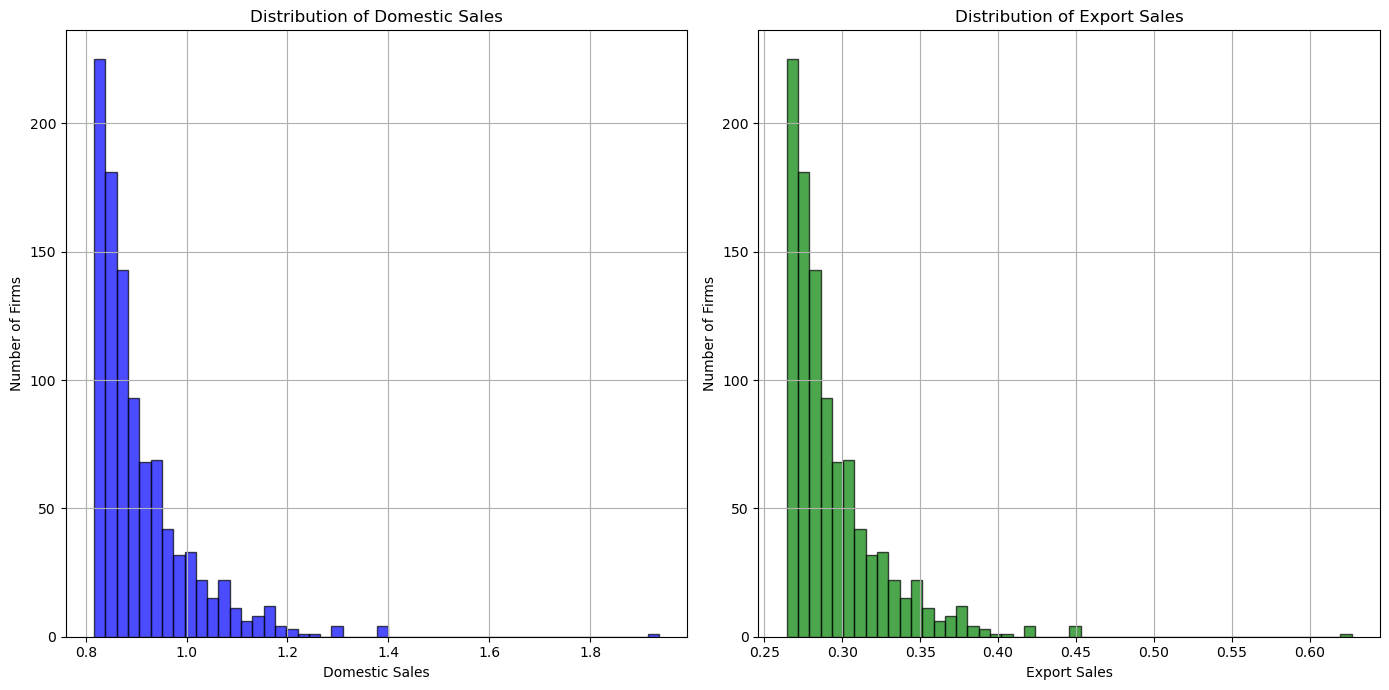

In [4]:
# Plot the distribution of firms' domestic sales
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(y_d_list, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Domestic Sales')
plt.xlabel('Domestic Sales')
plt.ylabel('Number of Firms')
plt.grid(True)
# Plot the distribution of firms' export sales
plt.subplot(1, 2, 2)
plt.hist(y_x_list, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of Export Sales')
plt.xlabel('Export Sales')
plt.ylabel('Number of Firms')
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
#SMM estimation for parameters theta, sigma, f_o and f_x


import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize

# Set up model parameters
N = 1000  # Number of firms
A_bar = 1  # Minimum productivity level
P = 1  # Aggregate price level
Y = 100  # Aggregate demand
alpha = 0.5  # Output elasticity with respect to labor
w = 2  # Wage rate
tau = 0.1  # Tariff rate as a percentage


def simulate_moments(N, theta, sigma, f_o, f_x, P, Y, alpha, w):
    profits_list = []
    y_d_list = []
    y_x_list = []
    output_list = []
    labor_list = []
    domestic_prices_list = []
    export_prices_list = []
    sales_list = []
     
    for _ in range(N):
        # Draw a productivity level from Pareto distribution
        A = (np.random.pareto(theta) + 1) * A_bar
        p_d_domestic = find_optimal_price_domestic(A)
        p_d_exporter, p_x_exporter = find_optimal_prices_exporters(A)

        # Calculate profits and quantities for domestic only scenario
        y_d_domestic = Y * (p_d_domestic / P)**(-sigma)
        costs_domestic = w * (y_d_domestic / A)**(1/alpha) + f_o
        profits_domestic = p_d_domestic * y_d_domestic - costs_domestic

        # Calculate profits and quantities for export scenario
        y_d_exporter = Y * (p_d_exporter / P)**(-sigma)
        y_x_exporter = Y * (p_x_exporter / P)**(-sigma)
        costs_exporter = w * ((y_d_exporter + y_x_exporter) / A)**(1/alpha) + f_o + f_x + tau * y_x_exporter
        profits_exporter = p_d_exporter * y_d_exporter + p_x_exporter * y_x_exporter - costs_exporter

        # Determine the firm's behavior based on profits
        if profits_domestic > 0 and profits_exporter > 0:
            # The firm will export
            profits = profits_exporter
            y_d = y_d_exporter
            y_x = y_x_exporter
            p_d = p_d_exporter
            p_x = p_x_exporter
        elif profits_domestic > 0 and profits_exporter <= 0:
            # The firm will only sell domestically
            profits = profits_domestic
            y_d = y_d_domestic
            y_x = 0
            p_d = p_d_domestic
            p_x = 0

        else:
            # The firm will not sell at all
            profits = 0
            y_d = 0
            y_x = 0
            p_d = 0
            p_x = 0
        output = y_d + y_x
        labor = (output / A)**(1 / alpha)

        profits_list.append(profits)
        y_d_list.append(y_d)
        y_x_list.append(y_x)
        output_list.append(output)
        labor_list.append(labor)
        sales_list.append(p_x * y_x + p_d * y_d)
         
    # Convert lists to numpy arrays 
    y_d_array = np.array(y_d_list)
    y_x_array = np.array(y_x_list)
    sales_array = np.array(sales_list)
    labor_array = np.array(labor_list)

    # Average Sale
    average_sale = np.mean(sales_array)

    # Average Export (only for firms that export)
    exporters = y_x_array > 0
    average_export = np.mean(y_x_array[exporters]) if np.any(exporters) else 0

    # Fraction of Firms that Export
    fraction_exporting = np.mean(exporters)

    # Average Employment for Domestic Firms
    domestic_only = (y_d_array > 0) & (y_x_array == 0)
    average_employment_domestic = np.mean(labor_array[domestic_only]) if np.any(domestic_only) else 0

           

         
    return average_sale, average_export, fraction_exporting, average_employment_domestic  

def smm_objective(params, observed_moments, N):
    theta, sigma, f_o, f_x = params
    simulated = simulate_moments(N, theta, sigma, f_o, f_x, P=1, Y=100, alpha=0.5, w=1)
    moment_diffs = np.array(simulated) - np.array(observed_moments)
    return np.sum(moment_diffs**2)

# Observed moments (these would come from actual data in practice)
observed_moments = [observed_average_sale, observed_average_export, observed_fraction_exporting, observed_average_employment_domestic]

# Optimization to find best parameters
initial_guess = [3.5, 2.4, 1.2, 4]  # Initial guesses for theta, sigma, f_o, f_x
result = minimize(smm_objective, initial_guess, args=(observed_moments, 1000), method='Nelder-Mead')

print("Optimized Parameters:")
print("Theta (shape of Pareto):", result.x[0])
print("Sigma (elasticity of substitution):", result.x[1])
print("f_o (fixed operational cost):", result.x[2])
print("f_x (fixed export cost):", result.x[3])

Optimized Parameters:
Theta (shape of Pareto): 3.543408203125
Sigma (elasticity of substitution): 2.4009375
f_o (fixed operational cost): 1.2148828125
f_x (fixed export cost): 4.049609374999999


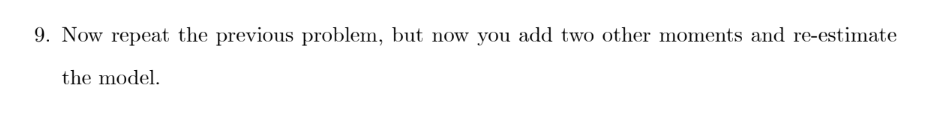

We choose mean and standard deviation of labor productivity.

In [6]:
#SMM estimation for parameters theta, sigma, f_o and f_x


import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize

# Set up model parameters
N = 1000  # Number of firms
A_bar = 1  # Minimum productivity level
P = 1  # Aggregate price level
Y = 100  # Aggregate demand
alpha = 0.5  # Output elasticity with respect to labor
w = 2  # Wage rate
tau = 0.1  # Tariff rate as a percentage


def simulate_moments(N, theta, sigma, f_o, f_x, P, Y, alpha, w):
    profits_list = []
    y_d_list = []
    y_x_list = []
    output_list = []
    labor_list = []
    domestic_prices_list = []
    export_prices_list = []
    sales_list = []
     
    for _ in range(N):
        # Draw a productivity level from Pareto distribution
        A = (np.random.pareto(theta) + 1) * A_bar
        p_d_domestic = find_optimal_price_domestic(A)
        p_d_exporter, p_x_exporter = find_optimal_prices_exporters(A)

        # Calculate profits and quantities for domestic only scenario
        y_d_domestic = Y * (p_d_domestic / P)**(-sigma)
        costs_domestic = w * (y_d_domestic / A)**(1/alpha) + f_o
        profits_domestic = p_d_domestic * y_d_domestic - costs_domestic

        # Calculate profits and quantities for export scenario
        y_d_exporter = Y * (p_d_exporter / P)**(-sigma)
        y_x_exporter = Y * (p_x_exporter / P)**(-sigma)
        costs_exporter = w * ((y_d_exporter + y_x_exporter) / A)**(1/alpha) + f_o + f_x + tau * y_x_exporter
        profits_exporter = p_d_exporter * y_d_exporter + p_x_exporter * y_x_exporter - costs_exporter

        # Determine the firm's behavior based on profits
        if profits_domestic > 0 and profits_exporter > 0:
            # The firm will export
            profits = profits_exporter
            y_d = y_d_exporter
            y_x = y_x_exporter
            p_d = p_d_exporter
            p_x = p_x_exporter
        elif profits_domestic > 0 and profits_exporter <= 0:
            # The firm will only sell domestically
            profits = profits_domestic
            y_d = y_d_domestic
            y_x = 0
            p_d = p_d_domestic
            p_x = 0

        else:
            # The firm will not sell at all
            profits = 0
            y_d = 0
            y_x = 0
            p_d = 0
            p_x = 0
        output = y_d + y_x
        labor = (output / A)**(1 / alpha)

        profits_list.append(profits)
        y_d_list.append(y_d)
        y_x_list.append(y_x)
        output_list.append(output)
        labor_list.append(labor)
        sales_list.append(p_x * y_x + p_d * y_d)
         
    # Convert lists to numpy arrays 
    y_d_array = np.array(y_d_list)
    y_x_array = np.array(y_x_list)
    sales_array = np.array(sales_list)
    labor_array = np.array(labor_list)
    average_productivity = np.mean(prod_array)# moments for part 9
    std_productivity = np.std(prod_array)#moments for part 9
    std_sale = np.std(sales_array)#moments for part 9

    # Average Sale
    average_sale = np.mean(sales_array)

    # Average Export (only for firms that export)
    exporters = y_x_array > 0
    average_export = np.mean(y_x_array[exporters]) if np.any(exporters) else 0

    # Fraction of Firms that Export
    fraction_exporting = np.mean(exporters)

    # Average Employment for Domestic Firms
    domestic_only = (y_d_array > 0) & (y_x_array == 0)
    average_employment_domestic = np.mean(labor_array[domestic_only]) if np.any(domestic_only) else 0
    average_productivity = np.mean(prod_array) 
    std_productivity = np.std(prod_array) 
    std_sale = np.std(sales_array) 

           

         
    return average_sale, average_export, fraction_exporting, average_employment_domestic, average_productivity, std_productivity 

def smm_objective(params, observed_moments, N):
    theta, sigma, f_o, f_x = params
    simulated = simulate_moments(N, theta, sigma, f_o, f_x, P=1, Y=100, alpha=0.5, w=1)
    moment_diffs = np.array(simulated) - np.array(observed_moments)
    return np.sum(moment_diffs**2)

# Observed moments (these would come from actual data in practice)
observed_moments = [observed_average_sale, observed_average_export, observed_fraction_exporting, observed_average_employment_domestic, observed_average_productivity, observed_std_productivity]

# Optimization to find best parameters
initial_guess = [3.5, 2.4, 1.2, 4]  # Initial guesses for theta, sigma, f_o, f_x
result = minimize(smm_objective, initial_guess, args=(observed_moments, 1000), method='Nelder-Mead')

print("Optimized Parameters:")
print("Theta (shape of Pareto):", result.x[0])
print("Sigma (elasticity of substitution):", result.x[1])
print("f_o (fixed operational cost):", result.x[2])
print("f_x (fixed export cost):", result.x[3])

Optimized Parameters:
Theta (shape of Pareto): 3.606768798828125
Sigma (elasticity of substitution): 2.3996484375
f_o (fixed operational cost): 1.1953564453125
f_x (fixed export cost): 4.047021484375


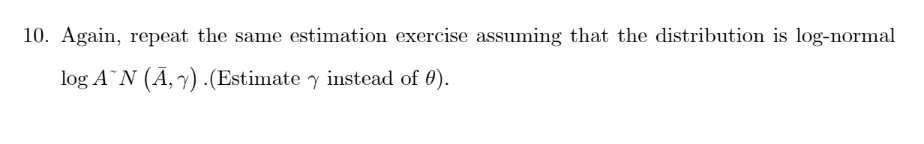

In [11]:
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import lognorm

# Set up model parameters
N = 1000  # Number of firms
gamma = 3.5  # Shape parameter of the Pareto distribution for A
A_bar = 1  # Minimum productivity level
sigma = 2.4  # Elasticity of substitution
P = 1  # Aggregate price level
Y = 100  # Aggregate demand
alpha = 0.5  # Output elasticity with respect to labor
f_o = 1.2  # Fixed operational cost
f_x = 4  # Fixed export cost
w = 2  # Wage rate
tau = 0.1  # Tariff rate as a percentage

# Define a function to calculate the optimal domestic price before firm joins exporters
def find_optimal_price_domestic(A):
    # Equation to find the optimal domestic price when the firm is not exporting (p_x = 0)
    def equation(p_d):
        return p_d - (sigma / (sigma - 1)) * (w / alpha) * A**(-alpha) * Y**(1/alpha - 1) * P**(sigma*(1/alpha - 1)) * p_d**(-sigma * (1/alpha - 1))
    # Initial guess for the domestic price
    initial_guess = [w]
    # Solve the equation to find the optimal domestic price
    p_d_optimal = fsolve(equation, initial_guess)[0]
    return p_d_optimal

# Define a function to calculate the optimal prices after firm joins exporters
def find_optimal_prices_exporters(A):
    # Define equations to find optimal prices when the firm is exporting
    def equations(p):
        p_d, p_x = p
        return (
            p_d - (sigma / (sigma - 1)) * (w / alpha) * A**(-alpha) * Y**(1/alpha - 1) * P**(sigma*(1/alpha - 1)) * (p_d**(-sigma) + p_x**(-sigma))**(1/alpha - 1),
            p_x - (sigma / (sigma + tau - 1)) * p_d
        )
    # Initial guess for the prices
    initial_guess = [w, w]
    # Solve the equations
    p_d, p_x = fsolve(equations, initial_guess)
    return p_d, p_x

# Simulate firms' behavior
profits_list = []
y_d_list = []
y_x_list = []
output_list = []
labor_list = []
domestic_prices_list = []
export_prices_list = []
sales_list = []
prod_list = []
for _ in range(N):
    # Draw a productivity level from Pareto distribution
    A = lognorm(s=gamma, scale=np.exp(A_bar)).rvs()
    p_d_domestic = find_optimal_price_domestic(A)
    p_d_exporter, p_x_exporter = find_optimal_prices_exporters(A)

    # Calculate profits and quantities for domestic only scenario
    y_d_domestic = Y * (p_d_domestic / P)**(-sigma)
    costs_domestic = w * (y_d_domestic / A)**(1/alpha) + f_o
    profits_domestic = p_d_domestic * y_d_domestic - costs_domestic

    # Calculate profits and quantities for export scenario
    y_d_exporter = Y * (p_d_exporter / P)**(-sigma)
    y_x_exporter = Y * (p_x_exporter / P)**(-sigma)
    costs_exporter = w * ((y_d_exporter + y_x_exporter) / A)**(1/alpha) + f_o + f_x + tau * y_x_exporter
    profits_exporter = p_d_exporter * y_d_exporter + p_x_exporter * y_x_exporter - costs_exporter

    # Determine the firm's behavior based on profits
    if profits_domestic > 0 and profits_exporter > 0:
        # The firm will export
        profits = profits_exporter
        y_d = y_d_exporter
        y_x = y_x_exporter
        p_d = p_d_exporter
        p_x = p_x_exporter
    elif profits_domestic > 0 and profits_exporter <= 0:
        # The firm will only sell domestically
        profits = profits_domestic
        y_d = y_d_domestic
        y_x = 0
        p_d = p_d_domestic
        p_x = 0
        
    else:
        # The firm will not sell at all
        profits = 0
        y_d = 0
        y_x = 0
        p_d = 0
        p_x = 0
    output = y_d + y_x
    labor = (output / A)**(1 / alpha)
    productivity = output / labor

    profits_list.append(profits)
    y_d_list.append(y_d)
    y_x_list.append(y_x)
    output_list.append(output)
    labor_list.append(labor)
    domestic_prices_list.append(p_d)
    export_prices_list.append(p_x)
    sales_list.append(p_x * y_x + p_d * y_d)
    prod_list.append(productivity)
    


C:\Users\fatem\AppData\Local\Temp\ipykernel_18068\194804709.py:96: RuntimeWarning: invalid value encountered in scalar divide
  productivity = output / labor


In [8]:
 
y_d_array = np.array(y_d_list)
y_x_array = np.array(y_x_list)
sales_array = np.array(sales_list)
labor_array = np.array(labor_list)
prod_array = np.array(prod_list)

# Average Sale
observed_average_sale = np.mean(sales_array)

# Average Export (only for firms that export)
exporters = y_x_array > 0
observed_average_export = np.mean(y_x_array[exporters]) if np.any(exporters) else 0

# Fraction of Firms that Export
observed_fraction_exporting = np.mean(exporters)

# Average Employment for Domestic Firms
domestic_only = (y_d_array > 0) & (y_x_array == 0)
observed_average_employment_domestic = np.mean(labor_array[domestic_only]) if np.any(domestic_only) else 0
observed_average_productivity = np.mean(prod_array)# moments for part 9
observed_std_productivity = np.std(prod_array)#moments for part 9
observed_std_sale = np.std(sales_array)#moments for part 9

C:\Users\fatem\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\fatem\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\fatem\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\fatem\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\fatem\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
#SMM estimation for parameters theta, sigma, f_o and f_x


import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize

# Set up model parameters
N = 1000  # Number of firms
A_bar = 1  # Minimum productivity level
P = 1  # Aggregate price level
Y = 100  # Aggregate demand
alpha = 0.5  # Output elasticity with respect to labor
w = 2  # Wage rate
tau = 0.1  # Tariff rate as a percentage


def simulate_moments(N, theta, sigma, f_o, f_x, P, Y, alpha, w):
    profits_list = []
    y_d_list = []
    y_x_list = []
    output_list = []
    labor_list = []
    domestic_prices_list = []
    export_prices_list = []
    sales_list = []
     
    for _ in range(N):
        # Draw a productivity level from Pareto distribution
        A = (np.random.pareto(theta) + 1) * A_bar
        p_d_domestic = find_optimal_price_domestic(A)
        p_d_exporter, p_x_exporter = find_optimal_prices_exporters(A)

        # Calculate profits and quantities for domestic only scenario
        y_d_domestic = Y * (p_d_domestic / P)**(-sigma)
        costs_domestic = w * (y_d_domestic / A)**(1/alpha) + f_o
        profits_domestic = p_d_domestic * y_d_domestic - costs_domestic

        # Calculate profits and quantities for export scenario
        y_d_exporter = Y * (p_d_exporter / P)**(-sigma)
        y_x_exporter = Y * (p_x_exporter / P)**(-sigma)
        costs_exporter = w * ((y_d_exporter + y_x_exporter) / A)**(1/alpha) + f_o + f_x + tau * y_x_exporter
        profits_exporter = p_d_exporter * y_d_exporter + p_x_exporter * y_x_exporter - costs_exporter

        # Determine the firm's behavior based on profits
        if profits_domestic > 0 and profits_exporter > 0:
            # The firm will export
            profits = profits_exporter
            y_d = y_d_exporter
            y_x = y_x_exporter
            p_d = p_d_exporter
            p_x = p_x_exporter
        elif profits_domestic > 0 and profits_exporter <= 0:
            # The firm will only sell domestically
            profits = profits_domestic
            y_d = y_d_domestic
            y_x = 0
            p_d = p_d_domestic
            p_x = 0

        else:
            # The firm will not sell at all
            profits = 0
            y_d = 0
            y_x = 0
            p_d = 0
            p_x = 0
        output = y_d + y_x
        labor = (output / A)**(1 / alpha)

        profits_list.append(profits)
        y_d_list.append(y_d)
        y_x_list.append(y_x)
        output_list.append(output)
        labor_list.append(labor)
        sales_list.append(p_x * y_x + p_d * y_d)
         
    # Convert lists to numpy arrays 
    y_d_array = np.array(y_d_list)
    y_x_array = np.array(y_x_list)
    sales_array = np.array(sales_list)
    labor_array = np.array(labor_list)

    # Average Sale
    average_sale = np.mean(sales_array)

    # Average Export (only for firms that export)
    exporters = y_x_array > 0
    average_export = np.mean(y_x_array[exporters]) if np.any(exporters) else 0

    # Fraction of Firms that Export
    fraction_exporting = np.mean(exporters)

    # Average Employment for Domestic Firms
    domestic_only = (y_d_array > 0) & (y_x_array == 0)
    average_employment_domestic = np.mean(labor_array[domestic_only]) if np.any(domestic_only) else 0

           

         
    return average_sale, average_export, fraction_exporting, average_employment_domestic  

def smm_objective(params, observed_moments, N):
    theta, sigma, f_o, f_x = params
    simulated = simulate_moments(N, theta, sigma, f_o, f_x, P=1, Y=100, alpha=0.5, w=1)
    moment_diffs = np.array(simulated) - np.array(observed_moments)
    return np.sum(moment_diffs**2)

# Observed moments (these would come from actual data in practice)
observed_moments = [observed_average_sale, observed_average_export, observed_fraction_exporting, observed_average_employment_domestic]

# Optimization to find best parameters
initial_guess = [3.5, 2.4, 1.2, 4]  # Initial guesses for theta, sigma, f_o, f_x
result = minimize(smm_objective, initial_guess, args=(observed_moments, 1000), method='Nelder-Mead')

print("Optimized Parameters:")
print("gamma (standard deviation of log transformed values):", result.x[0])
print("Sigma (elasticity of substitution):", result.x[1])
print("f_o (fixed operational cost):", result.x[2])
print("f_x (fixed export cost):", result.x[3])

Optimized Parameters:
gamma (standard deviation of log transformed values): 3.5
Sigma (elasticity of substitution): 2.4
f_o (fixed operational cost): 1.2
f_x (fixed export cost): 4.0
